In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


##### 1. Data Acquisition:

In [16]:
# Download historical data for Nifty IT Index
nifty_it = yf.download('^CNXIT', start='2010-01-01', end='2024-10-31', interval='1d')
nifty_it = nifty_it[['Close']].fillna(method='ffill')

nifty_it.tail()


[*********************100%%**********************]  1 of 1 completed


c:\ProgramData\anaconda3\envs\deeptrend\Lib\site-packages\yfinance\utils.py:788: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
C:\Users\Krunal Shambharkar\AppData\Local\Temp\ipykernel_14368\322929786.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nifty_it = nifty_it[['Close']].fillna(method='ffill')


,Close
Date,
2024-10-24,42139.851562
2024-10-25,42038.851562
2024-10-28,42205.398438
2024-10-29,42031.449219
2024-10-30,41668.601562


##### 2. Feturing Engineering

In [17]:
# 2. Data Preprocessing
# Calculate moving averages as features
nifty_it['MA_5'] = nifty_it['Close'].rolling(window=5).mean()
nifty_it['MA_20'] = nifty_it['Close'].rolling(window=20).mean()
nifty_it['Returns'] = nifty_it['Close'].pct_change()
nifty_it.dropna(inplace=True)
nifty_it.tail()


,Close,MA_5,MA_20,Returns
Date,,,,
2024-10-24,42139.851562,41853.990625,42199.698047,-0.001948
2024-10-25,42038.851562,41840.460938,42193.595703,-0.002397
2024-10-28,42205.398438,41969.000781,42188.235547,0.003962
2024-10-29,42031.449219,42127.530469,42192.502930,-0.004121
2024-10-30,41668.601562,42016.830469,42154.192969,-0.008633


In [18]:
# Scaling the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(nifty_it)
seq_length = 60

nifty_it.tail()

,Close,MA_5,MA_20,Returns
Date,,,,
2024-10-24,42139.851562,41853.990625,42199.698047,-0.001948
2024-10-25,42038.851562,41840.460938,42193.595703,-0.002397
2024-10-28,42205.398438,41969.000781,42188.235547,0.003962
2024-10-29,42031.449219,42127.530469,42192.502930,-0.004121
2024-10-30,41668.601562,42016.830469,42154.192969,-0.008633


In [19]:
# Create sequences and target variable shifted by one day for next-day prediction
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])  # Predicting 'Close' price
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, seq_length)

##### 3. Data Splitting:

In [7]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

##### 4. Model Implementation: 

In [8]:
# Hyperparameter Tuning
class LSTMHyperModel(kt.HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=16),
                       return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
        
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=16), return_sequences=True))
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
        
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=16)))
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
        
        model.add(Dense(1))

        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        optimizer = Adam(learning_rate=learning_rate)
        
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        return model

In [9]:
# Initialize the tuner with Bayesian optimization
tuner = kt.BayesianOptimization(
    LSTMHyperModel(),
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='Nifty_IT_LSTM'
)

Reloading Tuner from my_dir\Nifty_IT_LSTM\tuner0.json


In [10]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [11]:
# Start the search
tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping], batch_size=32)

In [12]:
# Retrieve the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"Units: {best_hyperparameters.get('units')}")
print(f"Dropout Rate: {best_hyperparameters.get('dropout')}")
print(f"Learning Rate: {best_hyperparameters.get('learning_rate')}")

Best Hyperparameters:
Units: 128
Dropout Rate: 0.5
Learning Rate: 0.01


In [13]:
# Retrain the best model on the full training data
history = best_model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), callbacks=[early_stopping], batch_size=32)

Epoch 1/50
82/82 [==============================] - 12s 103ms/step - loss: 14952639.0000 - val_loss: 14352462.0000
Epoch 2/50
82/82 [==============================] - 8s 98ms/step - loss: 12516973.0000 - val_loss: 4582454.0000
Epoch 3/50
82/82 [==============================] - 8s 94ms/step - loss: 3658050.7500 - val_loss: 3006721.0000
Epoch 4/50
82/82 [==============================] - 8s 96ms/step - loss: 3040834.7500 - val_loss: 2889078.5000
Epoch 5/50
82/82 [==============================] - 8s 96ms/step - loss: 1685600.7500 - val_loss: 1298209.8750
Epoch 6/50
82/82 [==============================] - 8s 96ms/step - loss: 880878.0000 - val_loss: 375488.9375
Epoch 7/50
82/82 [==============================] - 8s 96ms/step - loss: 292565.7812 - val_loss: 219379.9844
Epoch 8/50
82/82 [==============================] - 8s 94ms/step - loss: 224509.3281 - val_loss: 218762.3281
Epoch 9/50
82/82 [==============================] - 8s 94ms/step - loss: 219236.8906 - val_loss: 192184.2344
Epoc

##### 5. Model Evaluation

In [14]:
y_val_pred = best_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f'Validation RMSE: {rmse}')

21/21 [==============================] - 1s 25ms/step
Validation RMSE: 114.67424775004326


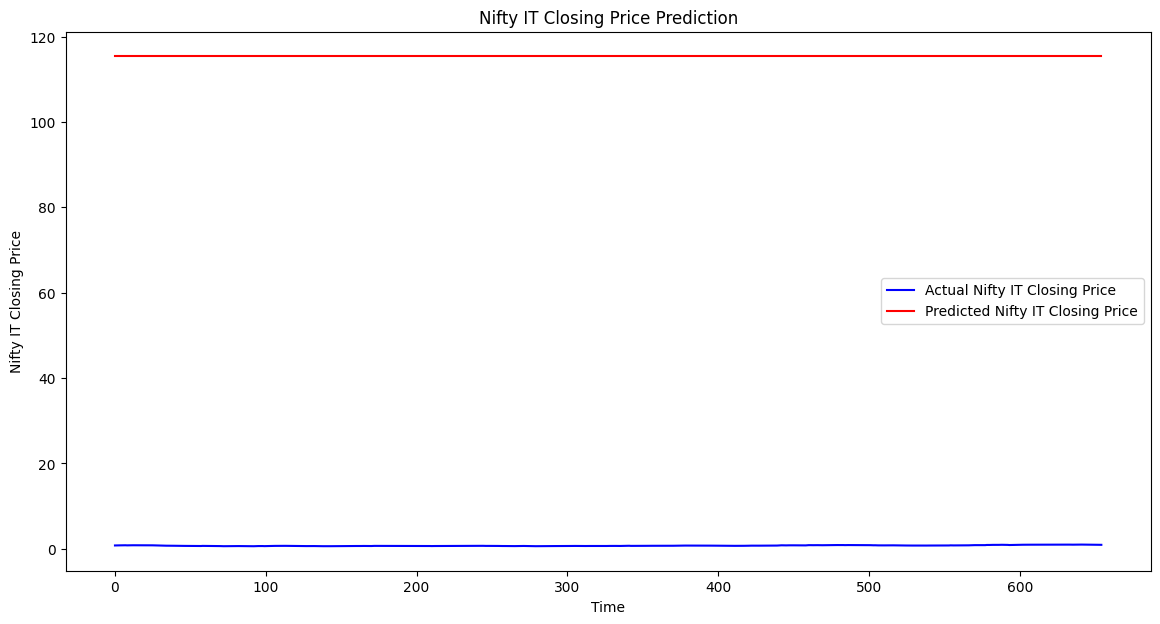

In [15]:
# Plotting actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_val, color='blue', label='Actual Nifty IT Closing Price')
plt.plot(y_val_pred, color='red', label='Predicted Nifty IT Closing Price')
plt.title('Nifty IT Closing Price Prediction')
plt.xlabel('Time')
plt.ylabel('Nifty IT Closing Price')
plt.legend()
plt.show()